### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
import matplotlib.pyplot as plt
import resnet

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import os
import pathlib

In [2]:
NUM_GPUS = 1
BS_PER_GPU = 128
BATCH_SIZE = 128
NUM_EPOCHS = 10

IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CHANNELS = 3
NUM_CLASSES = 8
NUM_TRAIN_SAMPLES = 40000

BASE_LEARNING_RATE = 0.1
LR_SCHEDULE = [(0.1, 30), (0.01, 45)]

In [3]:
def preprocess(x, y):
  x = tf.image.per_image_standardization(x)
  return x, y


def augmentation(x, y):
    x = tf.image.resize_with_crop_or_pad(
        x, IMG_HEIGHT + 8, IMG_WIDTH + 8)
    x = tf.image.random_crop(x, [IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS])
    x = tf.image.random_flip_left_right(x)
    return x, y	


def schedule(epoch):
  initial_learning_rate = BASE_LEARNING_RATE * BS_PER_GPU / 128
  learning_rate = initial_learning_rate
  for mult, start_epoch in LR_SCHEDULE:
    if epoch >= start_epoch:
      learning_rate = initial_learning_rate * mult
    else:
      break
  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

In [4]:
data_dir = pathlib.Path('/mnt/sdb/augere_export_class/')

DATASET_SIZE = len(list(data_dir.glob('*/*.png')))
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])
print ("Class names: ",class_names)

# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

Class names:  ['Anatomic landmarks' 'Unknown' 'Protruding lesions' 'Flat lesions'
 'Lumen' 'Mucosa' 'Normal' 'Excavated lesions']


In [5]:
for classes in class_names:
    class_samples = len(list(data_dir.glob(classes+'/*.png')))
    print('{0:18}: {1:3d}'.format(classes, class_samples))

print ('\nTotal number of images:', DATASET_SIZE)

Anatomic landmarks: 6868
Unknown           : 274
Protruding lesions: 583
Flat lesions      : 908
Lumen             : 1446
Mucosa            : 251
Normal            : 33129
Excavated lesions : 1252

Total number of images: 44711


In [6]:
def get_label_test(file_path):
    # Not used, mainly for log
    label = [i for i, s in enumerate(class_names) if 'Normal' in s]
    return np.uint8(label)
    
def get_label_int(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # get class integer from class-list
    label_int64 = tf.reduce_min(tf.where(tf.equal(parts[-2], class_names)))
    # cast to tensor array with dtype=uint8
    label_uint8 = tf.dtypes.cast(label_int64, tf.uint8)
    return tf.reshape(label_uint8, [-1])

def get_label_bool(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == class_names

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label_int(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

Class: ['Normal']


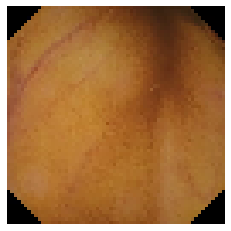

In [7]:
for image, label in labeled_ds.take(1):
    plt.figure()
    plt.imshow(image.numpy())
    plt.axis('off')
    print("Class:",class_names[label.numpy()])
    
#print(next(iter(labeled_ds)))

## Training
See https://lambdalabs.com/blog/tensorflow-2-0-tutorial-01-image-classification-basics/

https://github.com/lambdal/TensorFlow2-tutorial/tree/master/01-basic-image-classification

Splitting into training, test and validation data

In [8]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_ds = labeled_ds
train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [9]:
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("Full dataset sample size:", get_size(full_ds))
print ("Train dataset sample size:", get_size(train_ds))
print ("Test dataset sample size:", get_size(test_ds))
print ("Validation dataset sample size:", get_size(val_ds))

Full dataset sample size: 44711
Train dataset sample size: 31297
Test dataset sample size: 6706
Validation dataset sample size: 6708


In [10]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    #ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training dataset
train_ds = prepare_for_training(train_ds, cache="./train_ds.tfcache")
# Create test dataset
test_ds = prepare_for_training(test_ds, cache="./test_ds.tfcache")
# Create validation dataset
val_ds = prepare_for_training(val_ds, cache="./val_ds.tfcache")

In [11]:
tf.random.set_seed(22)
#train_dataset = train_dataset.map(augmentation).map(preprocess).shuffle(NUM_TRAIN_SAMPLES).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)
#test_dataset = test_dataset.map(preprocess).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)

input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
img_input = tf.keras.layers.Input(shape=input_shape)
opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

if NUM_GPUS == 1:
    model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)
    model.compile(
              optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
else:
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
      model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)
      model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])  

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = TensorBoard(
  log_dir=log_dir,
  update_freq='batch',
  histogram_freq=1)

lr_schedule_callback = LearningRateScheduler(schedule)


model.fit(train_ds,
          epochs=NUM_EPOCHS,
          validation_data=test_ds,
          validation_freq=1,
          #steps_per_epoch=245, if ds.repeat()
          #validation_steps=245,
          callbacks=[tensorboard_callback, lr_schedule_callback])

Epoch 1/10
245/245 [==============================] - 26s 108ms/step - loss: 0.8372 - sparse_categorical_accuracy: 0.9961 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/10
245/245 [==============================] - 15s 60ms/step - loss: 0.6855 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.6198 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/10
245/245 [==============================] - 15s 60ms/step - loss: 0.5631 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5091 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/10
245/245 [==============================] - 15s 61ms/step - loss: 0.4625 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4182 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/10
245/245 [==============================] - 15s 60ms/step - loss: 0.3799 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3435 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/10
245/245 [==============================] - 15s 61ms/step - loss: 0.312

Validate the results

In [ ]:
model.evaluate(test_dataset)

model.save('model.h5')

new_model = keras.models.load_model('model.h5')
 
new_model.evaluate(test_dataset)